In [1]:
import numpy as np
import pandas as pd

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
from matplotlib import pyplot as plt

import lightgbm as lgb

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)

In [3]:
items = pd.read_csv('../sale-prediction/items.csv')
shops = pd.read_csv('../sale-prediction/shops.csv')
cats = pd.read_csv('../sale-prediction/item_categories.csv')
train = pd.read_csv('../sale-prediction/sales_train.csv')
test = pd.read_csv('../sale-prediction/test.csv').set_index('ID')
matrix = pd.read_csv('../sale-prediction写経/data_lag.csv')

In [4]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11
#かぶっている店の名前を変更。ほかにもあって気がするが。
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']] #この二つだけにしちゃうんだ
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id', 'type_code', 'subtype_code']]
items.drop(['item_name'], axis=1, inplace=True)

In [5]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num', 'shop_id', 'item_id', col]]
    for i in lags:
        shifted = tmp.copy() #forの性質上の理由
        shifted.columns = ['date_block_num', 'shop_id', 'item_id', col+'_lag_'+str(i)] #ずらしたカラム名
        shifted['date_block_num'] += i #date_block_numをずらす
        df = pd.merge(df, shifted, on=['date_block_num', 'item_id', 'shop_id'], how='left')
    return df

In [6]:
matrix

,Unnamed: 0,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_12,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1
0,0,0,2,19,0.0,0,40,11,4,0.0,...,0.0000,0.0000,0.000,0.00000,0.00000,0.00000,0.0000,0.0,0.0000,0.0000
1,1,0,2,27,1.0,0,19,5,10,0.0,...,0.0000,0.0000,0.000,0.00000,0.00000,0.00000,0.0000,0.0,0.0000,0.0000
2,2,0,2,28,0.0,0,30,8,55,0.0,...,0.0000,0.0000,0.000,0.00000,0.00000,0.00000,0.0000,0.0,0.0000,0.0000
3,3,0,2,29,0.0,0,23,5,16,0.0,...,0.0000,0.0000,0.000,0.00000,0.00000,0.00000,0.0000,0.0,0.0000,0.0000
4,4,0,2,32,0.0,0,40,11,4,0.0,...,0.0000,0.0000,0.000,0.00000,0.00000,0.00000,0.0000,0.0,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,11127999,34,45,18454,0.0,20,55,13,2,1.0,...,0.2173,0.2069,0.000,0.12680,0.08930,0.12680,0.1354,0.5,0.1470,0.1969
11128000,11128000,34,45,16188,0.0,20,64,14,42,0.0,...,0.0000,0.0000,0.000,0.09450,0.10620,0.09450,0.1354,0.0,0.2373,0.1559
11128001,11128001,34,45,15757,0.0,20,55,13,2,0.0,...,0.2173,0.2069,0.248,0.12680,0.08930,0.12680,0.1354,0.0,0.1470,0.1969
11128002,11128002,34,45,19648,0.0,20,40,11,4,0.0,...,0.2422,0.2274,0.000,0.08374,0.09705,0.08374,0.1354,0.0,0.2242,0.2208


In [7]:
matrix.drop('Unnamed: 0', axis=1, inplace=True)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_12,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1
0,0,2,19,0.0,0,40,11,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2,27,1.0,0,19,5,10,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,28,0.0,0,30,8,55,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2,29,0.0,0,23,5,16,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2,32,0.0,0,40,11,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### ここから

## Trend features

In [9]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)
# アイテムごとの価格の平均値を出す。

In [10]:
group = train.groupby(['date_block_num', 'item_id']).agg({'item_price': 'mean'})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float64)
# その月のアイテムごとの価格の平均値を出す。

In [11]:
lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')
# ラグ化

In [14]:
for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
    (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

# その月のそのアイテムの値段の平均値がどれくらい全体の平均値とずれているのかを算出
# そのアイテムの平均値で割っているのは値段による特徴量の影響度を調整するため
# その月の平均値ではなく、ラグの方の平均値にあてはめている        

In [16]:
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)
matrix

# これはマジで理解できていない

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag_4,delta_price_lag_5,delta_price_lag_6,delta_price_lag
0,0,2,19,0.0,0,40,11,4,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,0,2,27,1.0,0,19,5,10,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2,0,2,28,0.0,0,30,8,55,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
3,0,2,29,0.0,0,23,5,16,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
4,0,2,32,0.0,0,40,11,4,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,20,55,13,2,1.0,0.0,...,99.0,98.947368,199.000000,-0.475149,-0.475149,-0.475149,-0.475149,-0.475428,0.055003,-0.475098
11128000,34,45,16188,0.0,20,64,14,42,0.0,0.0,...,NaN,NaN,NaN,0.081146,-0.027075,NaN,NaN,NaN,NaN,0.081116
11128001,34,45,15757,0.0,20,55,13,2,0.0,0.0,...,229.0,229.000000,208.090909,0.155836,0.155836,0.155836,0.155836,0.155836,0.050301,0.155884
11128002,34,45,19648,0.0,20,40,11,4,0.0,0.0,...,99.0,99.000000,99.000000,-0.091975,0.008917,-0.033303,0.008917,0.008917,0.008917,-0.091980


In [19]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag_4,delta_price_lag_5,delta_price_lag_6,delta_price_lag
0,0,2,19,0.0,0,40,11,4,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,0,2,27,1.0,0,19,5,10,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2,0,2,28,0.0,0,30,8,55,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
3,0,2,29,0.0,0,23,5,16,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
4,0,2,32,0.0,0,40,11,4,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,20,55,13,2,1.0,0.0,...,99.0,98.947368,199.000000,-0.475149,-0.475149,-0.475149,-0.475149,-0.475428,0.055003,-0.475098
11128000,34,45,16188,0.0,20,64,14,42,0.0,0.0,...,NaN,NaN,NaN,0.081146,-0.027075,NaN,NaN,NaN,NaN,0.081116
11128001,34,45,15757,0.0,20,55,13,2,0.0,0.0,...,229.0,229.000000,208.090909,0.155836,0.155836,0.155836,0.155836,0.155836,0.050301,0.155884
11128002,34,45,19648,0.0,20,40,11,4,0.0,0.0,...,99.0,99.000000,99.000000,-0.091975,0.008917,-0.033303,0.008917,0.008917,0.008917,-0.091980


In [20]:
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

# delta_price_lagを残してすべて削除

In [24]:
train['revenue'] = train.item_price * train.item_cnt_day
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)
#その月のショップごとの売り上げの合計

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

In [25]:
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})

In [27]:
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

#shopの平均的な売り上げ

In [28]:
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

#その月のshopの売り上げとshopの平均的な売り上げのずれを算出しラグ化

In [31]:
matrix.drop(['date_shop_revenue', 'shop_avg_revenue', 'delta_revenue'], axis=1, inplace=True)
#ラグ特徴量以外削除

## Special features

In [35]:
matrix.itertuples

<bound method DataFrame.itertuples of           date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0                      0        2       19             0.0          0   
1                      0        2       27             1.0          0   
2                      0        2       28             0.0          0   
3                      0        2       29             0.0          0   
4                      0        2       32             0.0          0   
...                  ...      ...      ...             ...        ...   
11127999              34       45    18454             0.0         20   
11128000              34       45    16188             0.0         20   
11128001              34       45    15757             0.0         20   
11128002              34       45    19648             0.0         20   
11128003              34       45      969             0.0         20   

          item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0       

In [39]:
ts = time.time()

cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():
    key = str(row.item_id) + ' '+ str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num

time.time() - ts

# 少し難しいが、、、何がどうなってるかは理解。
# for文でiterrowsを使っているため、めっちゃ重い。

1382.0253295898438

In [47]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

C:\Users\user\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\user\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


574.667384147644

In [48]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id', 'shop_id'])['date_block_num'].transform('min')
#最初に売られた月ってこうやって出すんだ
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

C:\Users\user\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\user\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Final preparations

In [49]:
matrix = matrix[matrix.date_block_num > 11]
# !?
#最初の11か月のデータはラグ特徴量を持っていない。そしてこのデータはラグ特徴量としてそれ以降に反映されているからいらないよとのこと。

In [50]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)
    return df

matrix = fill_na(matrix)
# 売り上げが0だった場合をラグ特徴量に反映させる

In [51]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_x', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt_lag_1',
       'date_cat_avg_item_cnt_lag_2', 'date_cat_avg_item_cnt_lag_3',
       'date_cat_avg_item_cnt_lag_6', 'date_cat_avg_item_cnt_lag_12',
       'date_shop_cat_avg_item_cnt_lag_1', 'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_

In [ ]:
mat

In [52]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 45 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int64  
 1   shop_id                               int64  
 2   item_id                               int64  
 3   item_cnt_month                        float64
 4   city_code                             int64  
 5   item_category_id                      int64  
 6   type_code                             int64  
 7   subtype_code                          int64  
 8   item_cnt_month_lag_1                  float64
 9   item_cnt_month_lag_2                  float64
 10  item_cnt_month_lag_3                  float64
 11  item_cnt_month_lag_6                  float64
 12  item_cnt_month_lag_12                 float64
 13  date_avg_item_cnt_lag_1               float64
 14  date_item_avg_item_cnt_x              float64
 15  date_ite

In [53]:
matrix.to_csv('data2.csv')

## LightGBM

In [59]:
data = pd.read_csv('../sale-prediction写経/data2.csv')

In [60]:
data = data[['date_block_num',
             'shop_id',
             'item_id',
             'item_cnt_month',
             'city_code',
             'item_category_id', 
             'type_code',
             'subtype_code',
             'item_cnt_month_lag_1',
             'item_cnt_month_lag_2',
             'item_cnt_month_lag_3', 
             'item_cnt_month_lag_6',
             'item_cnt_month_lag_12',
             'date_avg_item_cnt_lag_1',
             'date_item_avg_item_cnt_x',
             'date_item_avg_item_cnt_lag_1',    
             'date_item_avg_item_cnt_lag_2',
             'date_item_avg_item_cnt_lag_3',
             'date_item_avg_item_cnt_lag_6',
             'date_item_avg_item_cnt_lag_12',
             'date_shop_avg_item_cnt_lag_1', 
             'date_shop_avg_item_cnt_lag_2',
             'date_shop_avg_item_cnt_lag_3',
             'date_shop_avg_item_cnt_lag_6',
             'date_shop_avg_item_cnt_lag_12',
             'date_cat_avg_item_cnt_lag_1',
             'date_cat_avg_item_cnt_lag_2', 
             'date_cat_avg_item_cnt_lag_3',
             'date_cat_avg_item_cnt_lag_6',
             'date_cat_avg_item_cnt_lag_12',
             'date_shop_cat_avg_item_cnt_lag_1',
             'date_shop_type_avg_item_cnt_lag_1',
             'date_shop_subtype_avg_item_cnt_lag_1',
             'date_city_avg_item_cnt_lag_1',
             'date_item_city_avg_item_cnt_lag_1',
             'date_type_avg_item_cnt_lag_1',
             'date_subtype_avg_item_cnt_lag_1', 
             'delta_price_lag',
             'date_shop_revenue_x', 
             'delta_revenue_lag_1',
             'item_shop_last_sale', 
             'item_shop_first_sale', 
             'item_first_sale',
             'item_last_sale']]

In [64]:
data['month'] = data['date_block_num'] % 12
data

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,date_shop_revenue_x,delta_revenue_lag_1,item_shop_last_sale,item_shop_first_sale,item_first_sale,item_last_sale,month
0,12,2,27,0.0,0,19,5,10,0.0,0.0,...,1.0340,1.0750,-0.2827,1032722.0,1.212,1,0,0,-1,0
1,12,2,30,0.0,0,40,11,4,0.0,0.0,...,0.2700,0.2915,-0.4834,1032722.0,1.212,1,0,0,-1,0
2,12,2,31,0.0,0,37,11,1,0.0,0.0,...,0.2700,0.2340,-0.1375,1032722.0,1.212,1,0,0,-1,0
3,12,2,32,1.0,0,40,11,4,0.0,0.0,...,0.2700,0.2915,-0.4072,1032722.0,1.212,-1,0,0,-1,0
4,12,2,33,1.0,0,37,11,1,1.0,2.0,...,0.2700,0.2340,-0.2253,1032722.0,1.212,1,0,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6639289,34,45,18454,0.0,20,55,13,2,1.0,0.0,...,0.1470,0.1969,-0.4750,NaN,-0.290,1,11,11,-1,10
6639290,34,45,16188,0.0,20,64,14,42,0.0,0.0,...,0.2373,0.1559,0.0811,NaN,-0.290,-1,2,2,-1,10
6639291,34,45,15757,0.0,20,55,13,2,0.0,0.0,...,0.1470,0.1969,0.1559,NaN,-0.290,1,22,22,-1,10
6639292,34,45,19648,0.0,20,40,11,4,0.0,0.0,...,0.2242,0.2208,-0.0920,NaN,-0.290,-1,11,11,-1,10


In [65]:
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [66]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [67]:
import lightgbm as lightgbm
ts=time.time()

categorical_features = ['shop_id', 'item_id', 'item_category_id', 'city_code', 'month', 'type_code', 'subtype_code']
lgb_train = lightgbm.Dataset(X_train, Y_train,
                             categorical_feature=categorical_features)
lgb_eval = lightgbm.Dataset(X_valid, Y_valid,
                            categorical_feature=categorical_features)
#https://www.kaggle.com/koyohoriuchi/starter-code-with-feature-eng-and-lgbm-lb-0-899/edit
params = {'objective' : 'regression',
          'metric' : 'rmse',
          'n_estimators' : 10000,
          'early_stopping_rounds':100,
          "num_leaves" : 150,
          "learning_rate" : 0.01,
          }

model = lightgbm.train(params, lgb_train,
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=1000)

time.time() - ts

C:\Users\user\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\user\Anaconda\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[1000]	training's rmse: 0.545175	valid_1's rmse: 0.672018
[2000]	training's rmse: 0.515666	valid_1's rmse: 0.667156
Early stopping, best iteration is:
[2632]	training's rmse: 0.50299	valid_1's rmse: 0.665086


2166.778290748596

In [68]:
import numpy as np
from sklearn.metrics import mean_squared_error
va_pred = model.predict(X_valid)
score = np.sqrt(mean_squared_error(Y_valid, va_pred))
score

0.65903386478211

In [69]:
ts = time.time()

Y_test = model.predict(X_test)

time.time() - ts
sub = pd.DataFrame({'ID': test.index,
                    'item_cnt_month': Y_test})

sub.to_csv('lgbm_lags_sub.csv', index=False)
#

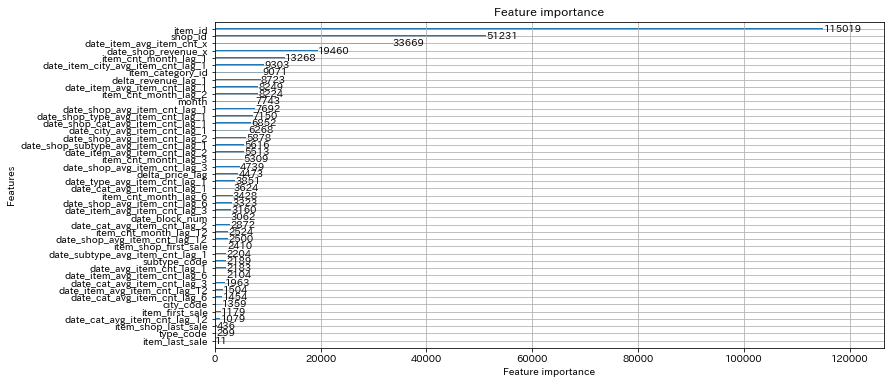

In [70]:
lightgbm.plot_importance(model, figsize=(12, 6))